# Import packages

In [1]:
# General libraries
import os
import time
import warnings
import pickle
import re
from tqdm import tqdm

# Data handling and visualization
import pandas as pd
import numpy as np

# Natural Language Processing (NLP)
import spacy

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.exceptions import FitFailedWarning
from sklearn.metrics import make_scorer


# Load data

In [11]:
# Get all csv files from distilbert_data folder
path = '../../data/02_processed/distilbert_data/train/'
all_files = [file for file in os.listdir(path) if file.endswith('text_clean.csv')]
all_files

['NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv',
 'EBIT_train__text_clean.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv',
 'NetIncomeLoss_train__text_clean.csv',
 'EarningsPerShareDiluted_train__text_clean.csv']

In [2]:
# Get all csv files from distilbert_data folder
fb_path = '../../data/02_processed/finbert_data/train/'
fb_files = [file for file in os.listdir(fb_path) if file.endswith('text_clean.csv')]
fb_files

['EarningsPerShareDiluted_train__text_clean.csv',
 'EBIT_train__text_clean.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv',
 'NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv',
 'NetIncomeLoss_train__text_clean.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv']

# Lemmatize text

In [4]:
# Initialize spacy en model
nlp = spacy.load('en_core_web_sm')

# Function to lemmatize text
def lemmatize_text(text):
    '''
    Lemmatize text using spacy's en_core_web_sm model
    '''
    sent = nlp(text)
    return ' '.join([token.lemma_ for token in sent])

In [15]:
for file in all_files:
    print(f'Processing {file}...')
    # Read csv file
    df = pd.read_csv(path + file)
    # Lemmatize text
    df['text'] = df['text'].apply(lemmatize_text)
    # Save lemmatized text to csv file
    df.to_csv(path + file[:-15] + '_lemma.csv', index=False)


Processing NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv...
Processing EBIT_train__text_clean.csv...


Processing NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv...
Processing RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv...
Processing NetIncomeLoss_train__text_clean.csv...
Processing EarningsPerShareDiluted_train__text_clean.csv...


In [5]:
for file in fb_files:
    print(f'Processing {file}...')
    # Read csv file
    df = pd.read_csv(fb_path + file)
    # Lemmatize text
    df['text'] = df['text'].apply(lemmatize_text)
    # Save lemmatized text to csv file
    df.to_csv(fb_path + file[:-15] + '_lemma.csv', index=False)


Processing EarningsPerShareDiluted_train__text_clean.csv...
Processing EBIT_train__text_clean.csv...
Processing NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv...
Processing NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv...
Processing NetIncomeLoss_train__text_clean.csv...
Processing RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv...


# Train random forest regressor

In [2]:
# Define the RSE scoring function
def rse_scorer(y_true, y_pred):
    true_mean = np.mean(y_true)
    squared_error_num = np.sum(np.square(y_true - y_pred))
    squared_error_den = np.sum(np.square(y_true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return -rse_loss  # Note the negative sign since GridSearchCV maximizes the score

# Function to train a random forest regressor on the preprocessed data
def train_random_forest_regressor(df, target_column, random_state=42):

    # Define the pipeline
    pipeline_tfidf = Pipeline([
        ('tfidf', TfidfVectorizer(max_df=0.95, min_df=round(len(df) * 0.05))),
        ('rf', RandomForestRegressor(random_state=random_state))
    ])

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'rf__n_estimators': [100, 200, 500],
        'rf__max_features': [1.0, 'sqrt', 'log2'],
        'rf__max_depth': [None, 4, 8],
        'rf__min_samples_split': [2, 10, 20],
        'rf__min_samples_leaf': [1, 5, 10]
    }
    
    # Add timer to record time
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FitFailedWarning)
        warnings.filterwarnings("ignore", category=UserWarning, message="One or more of the test scores are non-finite")

        # Perform grid search for TF-IDF
        with tqdm(total=len(param_grid['rf__n_estimators']) * len(param_grid['rf__max_features']) *
                len(param_grid['rf__max_depth']) * len(param_grid['rf__min_samples_split']) *
                len(param_grid['rf__min_samples_leaf']), desc='Grid Search Progress - TF-IDF') as pbar:

            start_time_tfidf = time.time()  # Record the start time

            grid_search_tfidf = GridSearchCV(pipeline_tfidf, param_grid, cv=10, scoring=make_scorer(rse_scorer), n_jobs=-1)
            grid_search_tfidf.fit(df['text'], df[target_column])

            end_time_tfidf = time.time()  # Record the end time
            elapsed_time_tfidf = end_time_tfidf - start_time_tfidf  # Calculate the elapsed time

            pbar.update(1)  # Update the progress bar

        # Access the best parameters and performance metrics for TF-IDF
        print(f"Best parameters for TF-IDF: {grid_search_tfidf.best_params_}")
        print(f"Best negative RSE score for TF-IDF: {grid_search_tfidf.best_score_}")
        print(f"Time taken for TF-IDF grid search: {elapsed_time_tfidf} seconds")
        

    return grid_search_tfidf
        

In [14]:
# Get all csv files from distilbert_data folder
path = '../../data/02_processed/distilbert_data/train/'
all_files = [file for file in os.listdir(path) if file.endswith('lemma.csv')]
all_files

['EBIT_train__lemma.csv',
 'NetIncomeLoss_train__lemma.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__lemma.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__lemma.csv',
 'NetCashProvidedByUsedInInvestingActivities_train__lemma.csv',
 'EarningsPerShareDiluted_train__lemma.csv']

In [20]:
all_files[0].split('.')[0].split('_')[0]

'EBIT'

In [7]:
# Get all csv files from distilbert_data folder
fb_path = '../../data/02_processed/finbert_data/train/'
fb_files = [file for file in os.listdir(fb_path) if file.endswith('lemma.csv')]
fb_files

['EBIT_train__lemma.csv',
 'NetIncomeLoss_train__lemma.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__lemma.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__lemma.csv',
 'NetCashProvidedByUsedInInvestingActivities_train__lemma.csv',
 'EarningsPerShareDiluted_train__lemma.csv']

## DistilBERT

In [15]:
# Loop through all csv files
for file in all_files:
    
    metric_name = file.split('.')[0].split('_')[0]
    
    print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")
    # Read csv file
    df = pd.read_csv(path + file)
    
    # Train models
    grid_search_tfidf = train_random_forest_regressor(df, 'target')
    
    # Save models
    # If folder not available, create folder
    if not os.path.exists('../../models/random_forest/':
        os.makedirs('../../models/random_forest/')
    # Save models to folder
    with open('../../models/random_forest/' + metric_name + '_TF-IDF.pkl', 'wb') as f:
        pickle.dump(grid_search_tfidf, f)
    
    #print(f"MODELS FOR {metric_name} SAVED TO ../models/random_forest/{metric_name}")
    print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
    print("\n")
    

--------------START TRAINING MODEL FOR EBIT--------------


Grid Search Progress - TF-IDF:   0%|          | 1/243 [00:54<3:39:01, 54.30s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best negative RSE score for TF-IDF: -0.7542797278023227
Time taken for TF-IDF grid search: 54.30033564567566 seconds
--------------DONE TRAINING MODEL FOR EBIT--------------


--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Grid Search Progress - TF-IDF:   0%|          | 1/243 [27:41<111:43:23, 1662.00s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Best negative RSE score for TF-IDF: -0.6191640708848944
Time taken for TF-IDF grid search: 1661.9945952892303 seconds
--------------DONE TRAINING MODEL FOR NetIncomeLoss--------------


--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Grid Search Progress - TF-IDF:   0%|          | 1/243 [16:09<65:08:41, 969.10s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best negative RSE score for TF-IDF: -0.46042747612464
Time taken for TF-IDF grid search: 969.0958104133606 seconds
--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Grid Search Progress - TF-IDF:   0%|          | 0/243 [00:00<?, ?it/s]/home/nguyenk/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:990: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
Grid Search Progress - TF-IDF:   0%|          | 1/243 [00:34<2:18:19, 34.30s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best negative RSE score for TF-IDF: -inf
Time taken for TF-IDF grid search: 34.29299759864807 seconds
--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Grid Search Progress - TF-IDF:   0%|          | 1/243 [00:35<2:24:56, 35.94s/it]


Best parameters for TF-IDF: {'rf__max_depth': 4, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best negative RSE score for TF-IDF: -1.7349015629101796
Time taken for TF-IDF grid search: 35.93071484565735 seconds
--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Grid Search Progress - TF-IDF:   0%|          | 1/243 [01:13<4:55:16, 73.21s/it]

Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Best negative RSE score for TF-IDF: -0.8755811797830078
Time taken for TF-IDF grid search: 73.20788645744324 seconds
--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




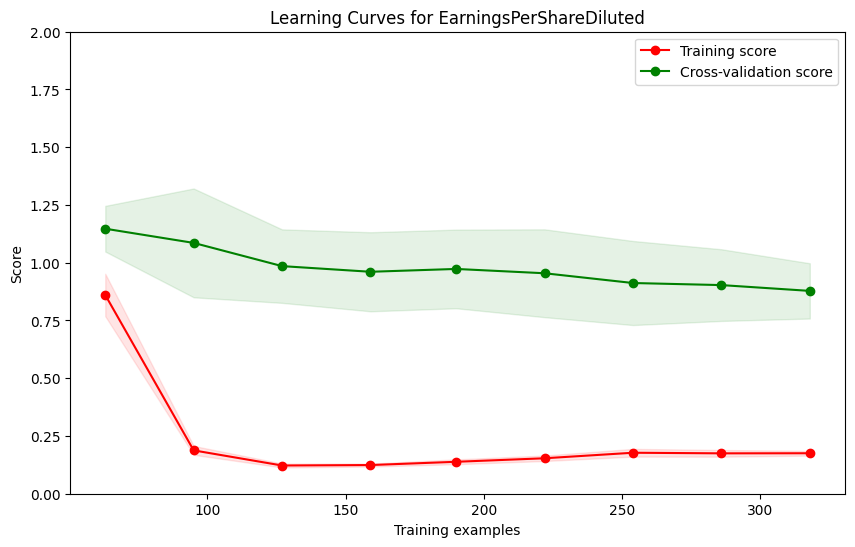

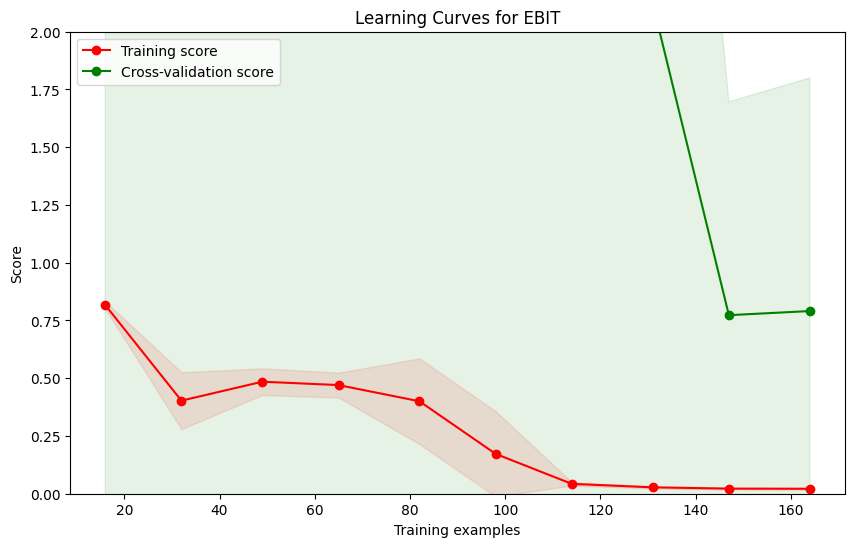

c:\Users\Khanh Le Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


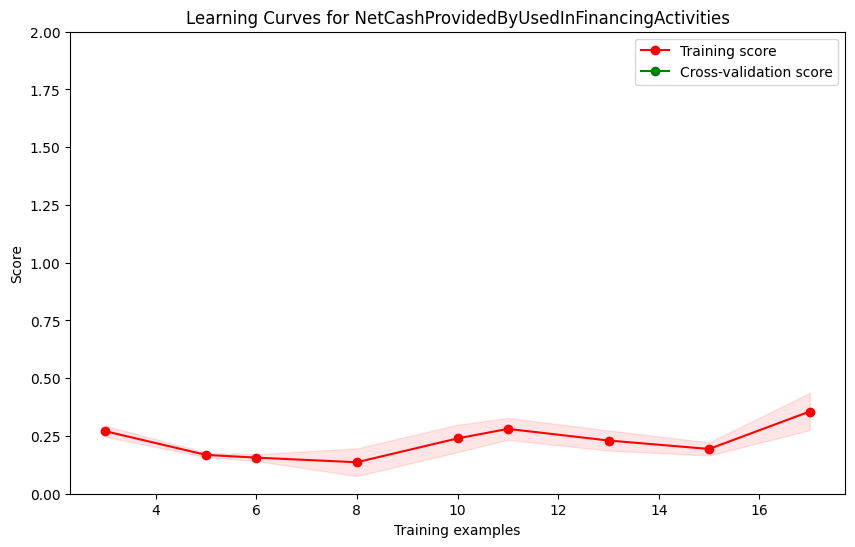

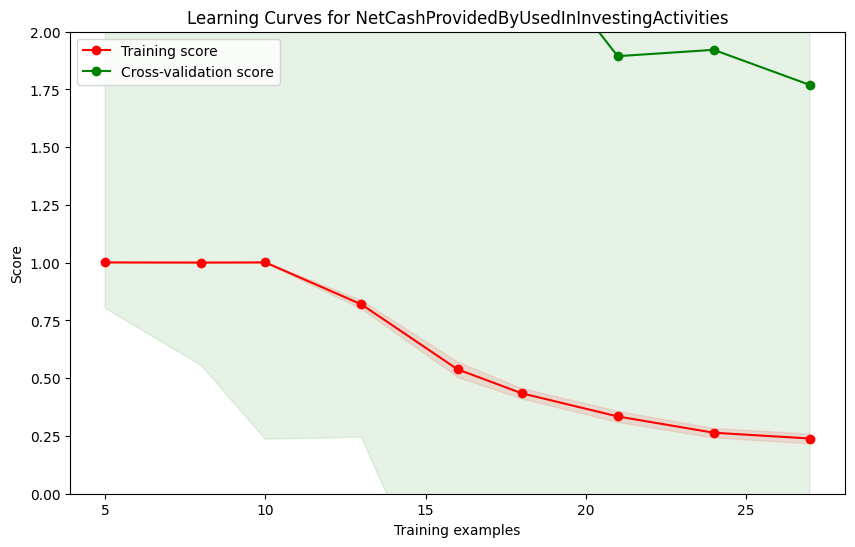

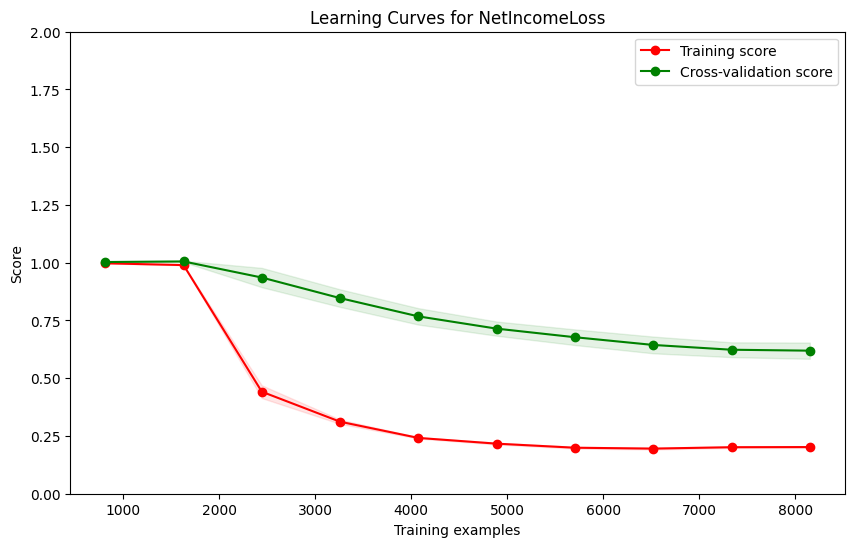

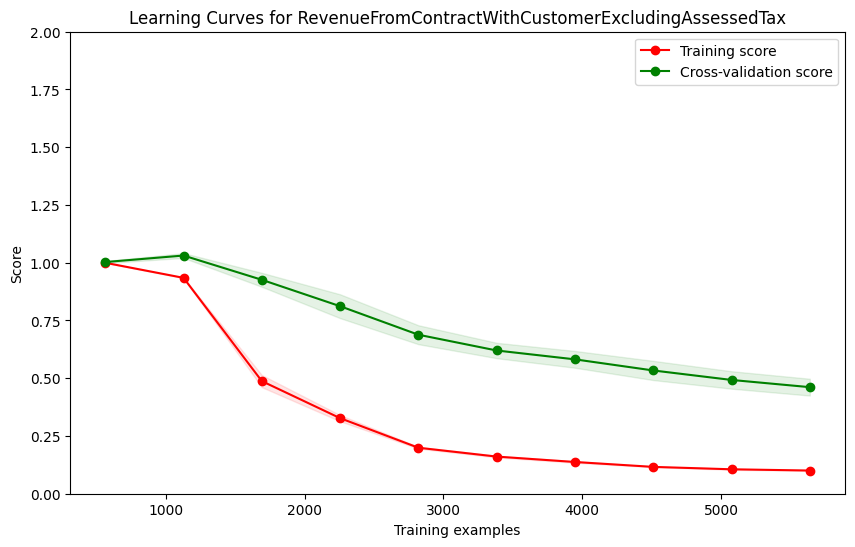

In [5]:
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curves_for_best_estimators(model_directory, data_directory, scorer, random_state=42):
    # List all files in the directory containing the saved GridSearchCV models
    model_files = [f for f in os.listdir(model_directory) if f.endswith('.pkl')]
    

    for model_file in model_files:
        # Determine the corresponding dataset file
        dataset_file = model_file.split('_')[0] + '_train__lemma.csv'
        
        # Determine the metric name
        metric_name = model_file.split('_')[0]
        
        # Load the dataset
        df = pd.read_csv(os.path.join(data_directory, dataset_file))
        
        # Splitting data into features and target
        X = df['text']
        y = df['target']
        
        # Load the GridSearchCV model
        with open(os.path.join(model_directory, model_file), 'rb') as file:
            grid_search = pickle.load(file)

        # Extract the best estimator
        best_estimator = grid_search.best_estimator_

        # Generate learning curves for the best estimator
        train_sizes, train_scores, validation_scores = learning_curve(
            estimator=best_estimator,
            X=X,
            y=y,
            train_sizes=np.linspace(0.1, 1.0, 10),
            cv=10,
            scoring=scorer,
            n_jobs=-1,
            random_state=random_state
        )
        
        # Calculate mean and standard deviation for training set scores
        train_scores_mean = -train_scores.mean(axis=1)
        train_scores_std = train_scores.std(axis=1)

        # Calculate mean and standard deviation for validation set scores
        validation_scores_mean = -validation_scores.mean(axis=1)
        validation_scores_std = validation_scores.std(axis=1)

        # Plot learning curves
        plt.figure(figsize=(10, 6))
        plt.title(f"Learning Curves for {metric_name}")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.ylim(0.0, 2.0)
        
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                        validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
        
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.show()

db_model_path = '../../models/random_forest/distilbert_data/'
db_file_path = '../../data/02_processed/distilbert_data/train/'
plot_learning_curves_for_best_estimators(db_model_path, db_file_path, make_scorer(rse_scorer))

## FinBERT

In [8]:
# Loop through all csv files
for file in fb_files:
    
    metric_name = file.split('.')[0].split('_')[0]
    
    print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")
    # Read csv file
    df = pd.read_csv(fb_path + file)
    
    # Train models
    grid_search_tfidf = train_random_forest_regressor(df, 'target')
    
    # Save models
    # If folder not available, create folder
    if not os.path.exists('../../models/random_forest/finbert_data/' + metric_name):
        os.makedirs('../../models/random_forest/finbert_data/' + metric_name)
    # Save models to folder
    with open('../../models/random_forest/finbert_data/' + metric_name + "/" + metric_name + '_TF-IDF.pkl', 'wb') as f:
        pickle.dump(grid_search_tfidf, f)
    
    #print(f"MODELS FOR {metric_name} SAVED TO ../models/random_forest/{metric_name}")
    print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
    print("\n")
    

--------------START TRAINING MODEL FOR EBIT--------------


Grid Search Progress - TF-IDF:   0%|          | 0/243 [00:00<?, ?it/s]

Grid Search Progress - TF-IDF:   0%|          | 1/243 [01:27<5:54:34, 87.91s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best negative RSE score for TF-IDF: -0.6669048019961213
Time taken for TF-IDF grid search: 87.90625762939453 seconds
--------------DONE TRAINING MODEL FOR EBIT--------------


--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Grid Search Progress - TF-IDF:   0%|          | 1/243 [30:13<121:52:28, 1813.01s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 500}
Best negative RSE score for TF-IDF: -0.6342420321432882
Time taken for TF-IDF grid search: 1813.0084145069122 seconds
--------------DONE TRAINING MODEL FOR NetIncomeLoss--------------


--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Grid Search Progress - TF-IDF:   0%|          | 1/243 [16:42<67:23:30, 1002.52s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Best negative RSE score for TF-IDF: -0.4540991742725146
Time taken for TF-IDF grid search: 1002.5164189338684 seconds
--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Grid Search Progress - TF-IDF:   0%|          | 0/243 [00:00<?, ?it/s]/home/nguyenk/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:990: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
Grid Search Progress - TF-IDF:   0%|          | 1/243 [00:35<2:22:42, 35.38s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best negative RSE score for TF-IDF: -inf
Time taken for TF-IDF grid search: 35.37861776351929 seconds
--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Grid Search Progress - TF-IDF:   0%|          | 1/243 [00:37<2:31:41, 37.61s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best negative RSE score for TF-IDF: -2.7234771667435083
Time taken for TF-IDF grid search: 37.60647773742676 seconds
--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Grid Search Progress - TF-IDF:   0%|          | 1/243 [01:08<4:36:27, 68.54s/it]

Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Best negative RSE score for TF-IDF: -0.8471041113563806
Time taken for TF-IDF grid search: 68.53978109359741 seconds
--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




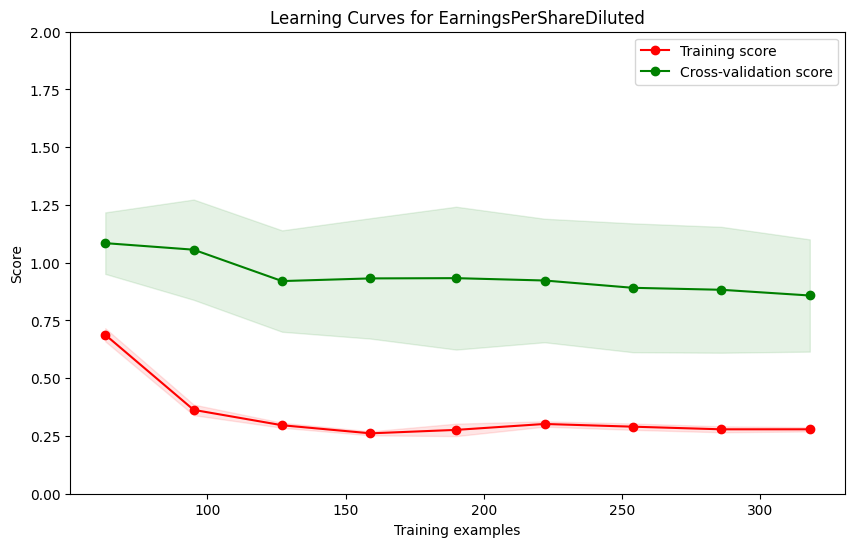

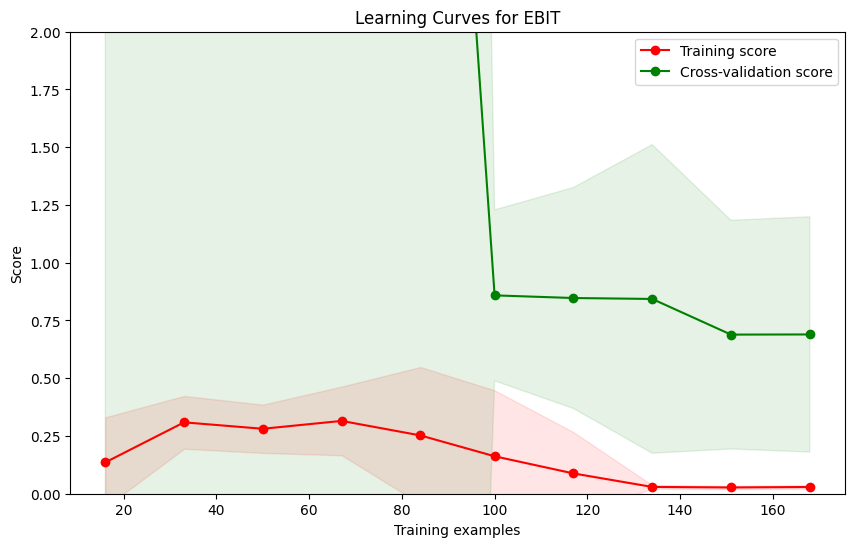

c:\Users\Khanh Le Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


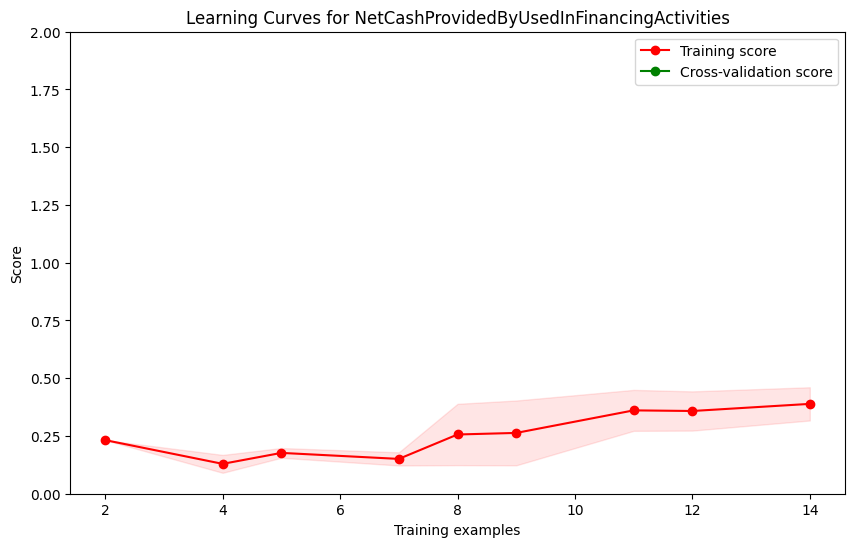

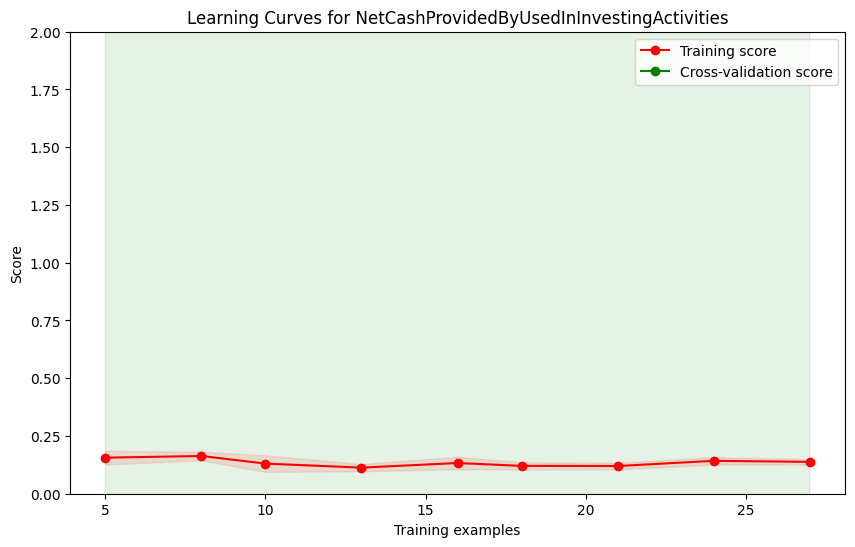

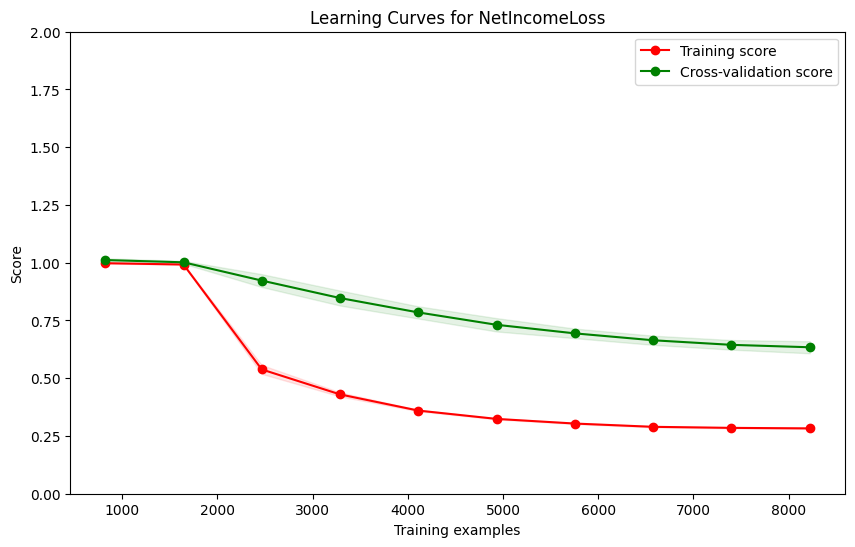

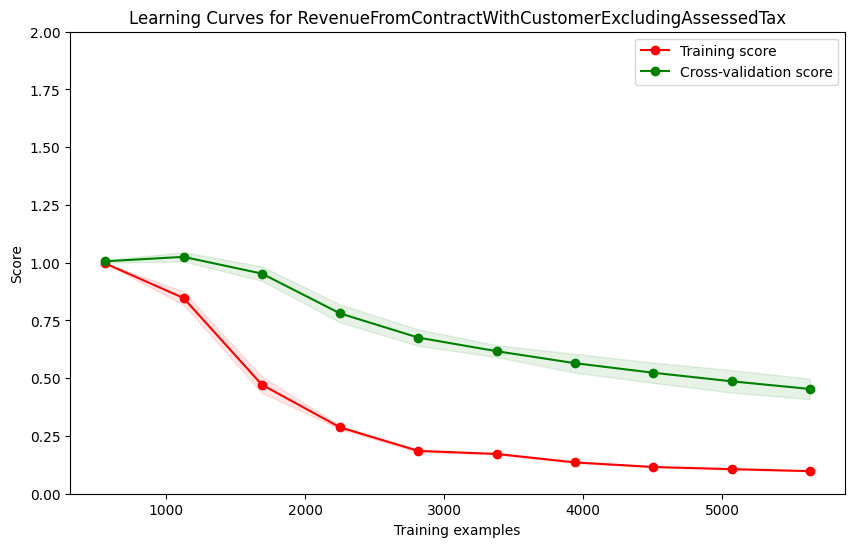

In [6]:
fb_model_path = '../../models/random_forest/finbert_data/'
fb_file_path = '../../data/02_processed/finbert_data/train/'
plot_learning_curves_for_best_estimators(fb_model_path, fb_file_path, make_scorer(rse_scorer))